In [1]:
import os
import glob
import numpy as np
import pandas as pd

from typing import Tuple, Sequence, Callable
import cv2

from PIL import Image
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
# from torchinfo import summary

from torchvision import transforms
from torchvision.models import resnet50

import re
import random
import time
import copy

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import random
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True  
seed_everything()

In [5]:
def onehot_label(row):
    p = re.compile('[A-Z]+')
    multi_label = row.split('/')[2].split('_')[1]
    multi_label = p.findall(multi_label)
    multi_label_list = torch.LongTensor([ord(alpha)-65 for alpha in multi_label[0]])
    y_onehot = torch.nn.functional.one_hot(multi_label_list, num_classes=10) 
    y_onehot = np.array(y_onehot.sum(dim=0).float())
    return y_onehot

In [6]:
## Create DataFrame for model filenames and labels

train_filename=glob.glob('data/train/*.JPG')
train_label_df = pd.DataFrame(train_filename, columns = ['filename'] )
test_filename=glob.glob('data/test/*.JPG')
test_label_df = pd.DataFrame(test_filename, columns = ['filename'] )
train_label_df['label'] = train_label_df.filename.apply(onehot_label)
test_label_df['label'] = test_label_df.filename.apply(onehot_label)

In [7]:
train_db = train_label_df.to_dict('records')
test_db=test_label_df.to_dict('records')

In [8]:
# print("train: ", len(train_db))
# # print('valid: ', len(valid_db))
# print("test: ", len(test_db))

In [9]:
class BlockDataset(Dataset):
    def __init__(
        self,
        label_db,
        transforms: Sequence[Callable]
    ) -> None:
        self.transforms = transforms

        self.labels = label_db

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        idx = self.labels[index]
        image_id = idx['filename']
        image = Image.open(
            os.path.join(
                image_id)).convert('RGB')
        target = idx['label']

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

In [10]:
transforms_train = transforms.Compose([
    transforms.CenterCrop((1800, 800)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.CenterCrop((1800, 800)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [11]:
train_dataset = BlockDataset(train_db, transforms_train)
test_dataset = BlockDataset(test_db, transforms_test)

In [12]:
dataloaders, batch_num = {}, {}
batch_size = 128

dataloaders['train']=DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
dataloaders['test']=DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

batch_num['train'], batch_num['test'] = len(dataloaders['train']),len(dataloaders['test'])
print('batch_size : %d,  number of batch(tvt) : %d / %d' % (batch_size, batch_num['train'], batch_num['test']))

batch_size : 128,  number of batch(tvt) : 174 / 85


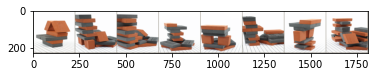

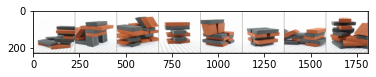

In [13]:
## Data Check
import torchvision
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 8

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out)
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out)

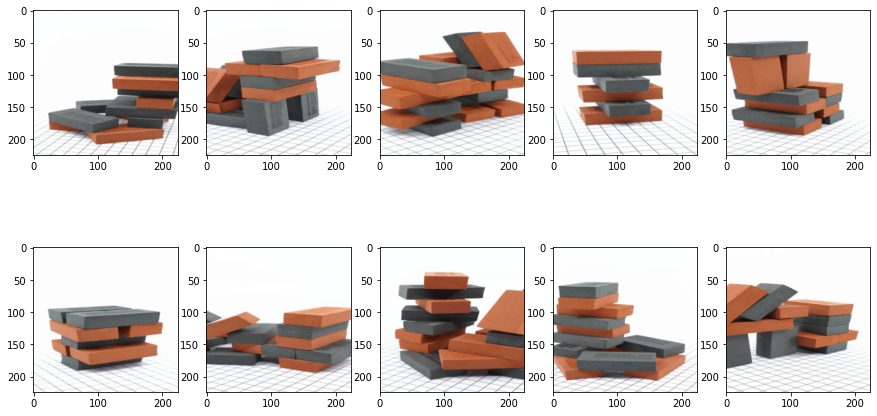

In [14]:
## Function to check tensor images in a batch
def check_image_from_tensor(check_image):
    
    num_image = 10
    if num_image <= 5:
        columns = num_image
        rows = 1
    else:
        columns = 5
        rows = int(np.ceil(num_image/columns))

    fig=plt.figure(figsize=(3*columns, 4*rows))

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    for i in range(1, num_image +1):
        inp = check_image[i-1].numpy().transpose((1, 2, 0))
        inp = std * inp + mean  
        inp = np.clip(inp, 0, 1)
        
        fig.add_subplot(rows, columns, i)

        plt.imshow(inp)
    plt.show()


num_show_img = 10
# data check
inputs, classes = next(iter(dataloaders['test']))
check_image = inputs[:num_show_img]
check_image_from_tensor(check_image)

## Model Training Section
-> Pre-trained model: 'best_model_cls_all.pt'  
If you do not wish to train the model, you can skip this section and proceed directly to the inference section.

In [16]:
# ! pip install efficientnet-pytorch

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=73ae7d27de62fa5fee2614b50fc6acf5d2e41c10d1c116843b3094974ca252ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-hwkehztb/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'  
save_model_name = 'eff-b3'
num_classes = 10 
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)

model = model.to(device)
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/work/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [19]:
# ! pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [20]:
from torchsummary import summary
print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 40, 112, 112]           1,080
       BatchNorm2d-3         [-1, 40, 112, 112]              80
MemoryEfficientSwish-4         [-1, 40, 112, 112]               0
         ZeroPad2d-5         [-1, 40, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 40, 112, 112]             360
       BatchNorm2d-7         [-1, 40, 112, 112]              80
MemoryEfficientSwish-8         [-1, 40, 112, 112]               0
          Identity-9             [-1, 40, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 10, 1, 1]             410
MemoryEfficientSwish-11             [-1, 10, 1, 1]               0
         Identity-12             [-1, 10, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 40, 1, 1]             440
         I

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        train_acc_list = []
        valid_acc_list = []

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs > 0.5
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum()
           
                num_cnt += len(labels)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float(running_corrects / 10 / num_cnt)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.2f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
           
            if phase == 'test' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> best model saved - %d / %.4f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.4f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_model_cls_all.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [22]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.0001, last_epoch=-1)
criterion = nn.MultiLabelSoftMarginLoss()
# criterion = torch.nn.BCELoss()
num_epochs = 10


In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

## Inference

In [25]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'  
save_model_name = 'eff-b3'
num_classes = 10 
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)


weights_path = 'best_model_cls_all.pt'
state_dict = torch.load(weights_path, map_location=device)  # load weight
model.load_state_dict(state_dict, strict=False)  # insert weight to model structure


model = model.to(device)

Loaded pretrained weights for efficientnet-b3


In [27]:
# ! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import tqdm

correct = 0
total = 0

model.eval()
pred = []
label = []
i = 0

with torch.no_grad():
    for data in tqdm.tqdm(dataloaders['test']):

        images, labels = data
        inputs = images.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = outputs > 0.5       
        pred+=preds.tolist()
        label+=labels.tolist()
        
        total += labels.size(0)

        correct += (preds == labels).sum()
        i+=1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / 10/ total))